### Bibliotecas

In [1]:
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.random import default_rng

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

from tqdm import tqdm

### Graphics font properties

In [2]:
fontsize = 8

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",
    "font.size": fontsize,
})

### Problemas

In [3]:
def MOP1(x):
    n = x.size
    z1 = 1 - np.exp(-np.sum((x - 1 / np.sqrt(n))**2))
    z2 = 1 - np.exp(-np.sum((x + 1 / np.sqrt(n))**2))
    return np.array([z1, z2])

### Condição de dominância

In [4]:
def dominates(x, y):
    return np.all(x["cost"] <= y["cost"]) and np.any(x["cost"] < y["cost"])

### Ordenação não dominada

In [5]:
def non_dominated_sorting(pop, n_pop):
    for i in range(n_pop):
        pop[i]["domination_set"] = np.array([], dtype=int)
        pop[i]["dominated_count"] = 0
    
    F = dict()
    F[1] = np.array([], dtype=int)
    
    for i in range(n_pop):
        for j in range(i + 1, n_pop):
            p = pop[i]
            q = pop[j]
            
            if dominates(p, q):
                p["domination_set"] = np.insert(p["domination_set"], p["domination_set"].size, j)
                q["dominated_count"] += 1
            
            if dominates(q, p):
                q["domination_set"] = np.insert(q["domination_set"], q["domination_set"].size, i)
                p["dominated_count"] += 1
            
            pop[i] = p
            pop[j] = q
            
        if pop[i]["dominated_count"] == 0: # se o ponto i nunca foi dominado
            F[1] = np.insert(F[1], F[1].size, i)
            pop[i]["rank"] = 1
    
    k = 1
    while True:
        Q = np.array([], dtype=int)
        
        for i in F[k]:
            p = pop[i]
            
            for j in p["domination_set"]:
                q = pop[j]
                q["dominated_count"] -= 1
                
                if q["dominated_count"] == 0:
                    Q = np.insert(Q, Q.size, j)
                    q["rank"] = k + 1
                
                pop[j] = q
                
        if Q.size == 0:
            break
        
        F[k + 1] = Q
        k = k + 1

    return pop, F

### Distância de aglomeração

In [6]:
def crowding_distance(pop, F, n_obj):
    n_F = np.array(list(F.keys()), dtype=int)

    for k in n_F:
        costs = np.zeros((n_obj, F[k].size))

        for i, m in enumerate(F[k]):
            costs[:, i] = pop[m]["cost"]
        
        n = F[k].size
        d = np.zeros((n, n_obj))

        for j in range(n_obj):
            so = np.argsort(costs[j, :], kind="stable")
            cj = costs[j, so]
            
            d[so[0], j] = np.inf
            
            for i in range(1, n - 1):
                d[so[i], j] = np.abs(cj[i + 1] - cj[i - 1]) / np.abs(cj[0] - cj[-1])
            
            d[so[-1], j] = np.inf

        for i in range(n):
            pop[F[k][i]]["crowding_distance"] = np.sum(d[i, :])
            
    return pop

### Ordenação da população

In [7]:
def sort_population(pop, n_pop):
    unsorted_pop = pop.copy()
    
    crowding_distance = np.zeros(n_pop)
    for i, k in enumerate(range(n_pop)):
        crowding_distance[i] = unsorted_pop[k]["crowding_distance"]
        
    CDSO = np.flip(np.argsort(crowding_distance, kind="stable"))
    
    sorted_pop = dict()
    for i, k in enumerate(CDSO):
        sorted_pop[i] = unsorted_pop[k]
        
    unsorted_pop = sorted_pop.copy()
    
    rank = np.zeros(n_pop)
    for i, k in enumerate(range(n_pop)):
        rank[i] = unsorted_pop[k]["rank"]
        
    RSO = np.argsort(rank, kind="stable")
    
    sorted_pop = dict()
    for i, k in enumerate(RSO):
        sorted_pop[i] = unsorted_pop[k]
        
    F = dict()
    max_rank = int(np.max(rank)) + 1
    for r in range(1, max_rank):
        F[r] = np.argwhere(rank[RSO] == r).flatten()
        
    return sorted_pop, F

### Crossover

In [8]:
def crossover(x1, x2, var_min, var_max):
    alpha = np.random.uniform(low=0.0, high=1.0, size=x1.size)
    
    y1 = alpha * x1 + (1 - alpha) * x2
    y2 = alpha * x2 + (1 - alpha) * x1
    
    return y1, y2

### Mutação

In [9]:
def mutation(x, mu, sigma, n_var, var_min, var_max):
    n_mu = int(np.ceil(mu * n_var))
    
    rng = default_rng()
    j = rng.choice(n_var, size=n_mu, replace=False)

    if not np.isscalar(sigma):
        if sigma.size > 1:
            sigma = sigma[j]
    
    y = x.copy()
    y[j] = x[j] + sigma * np.random.standard_normal(size=j.size)
    
    return y

### Mesclar populações

In [10]:
def merge_pops(pop, popc, popm):
    pop_keys = np.array(list(pop.keys()), dtype=int)
    popc_keys = np.array(list(popc.keys()), dtype=int)
    popm_keys = np.array(list(popm.keys()), dtype=int)
    
    merged_pop = pop.copy()
    
    k = pop_keys[-1] + 1
    for i in popc_keys:
        merged_pop[k] = popc[i][1]
        k += 1
        merged_pop[k] = popc[i][2]
        k += 1
        
    for i in popm_keys:
        merged_pop[k] = popm[i]
        k += 1
        
    n_pop = k
        
    return merged_pop, n_pop

### Truncamento da população

In [11]:
def truncate_pop(pop, n_pop):
    truncated_pop = dict()
    for k in range(n_pop):
        truncated_pop[k] = pop[k]
        
    return truncated_pop

### Plotagem dos resultados

In [12]:
def plot_results(pop):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    for k in pop.keys():
        ax[0].plot(pop[k]["position"][0], pop[k]["position"][1], marker="o", markersize=5, color="C0")
        ax[1].plot(pop[k]["cost"][0], pop[k]["cost"][1], marker="o", markersize=5, color="C0")
    
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    ax[0].grid(alpha=0.2)
    
    ax[1].set_xlabel(r"$f_1(x_1,x_2)$")
    ax[1].set_ylabel(r"$f_2(x_1,x_2)$")
    ax[1].grid(alpha=0.2)
    
    fig.tight_layout()

### Função principal do NSGA-II

In [13]:
def nsga_ii(n_var, var_min, var_max, max_it, n_pop, p_crossover, p_mutation, mu, Fobj):
    n_obj = (Fobj(np.random.uniform(low=var_min, high=var_max, size=n_var))).size
    
    nCrossover = 2 * round(p_crossover * n_pop / 2)
    nMutation = round(p_mutation * n_pop)
    sigma = 0.1 * (var_max - var_min)
    
    pop = dict()
    for k in range(n_pop):
        pop[k] = dict()
        pop[k]["position"] = np.random.uniform(low=var_min, high=var_max, size=n_var)
        pop[k]["cost"] = Fobj(pop[k]["position"])
    
    for it in tqdm(range(1, max_it)):
        popc = dict()
        
        for k in range(nCrossover // 2):
            rand_indivs = np.random.randint(low=0, high=n_pop-1, size=2, dtype=int)
            p1 = pop[rand_indivs[0]]
            p2 = pop[rand_indivs[1]]
            
            popc[k] = dict()
            
            p1c, p2c = crossover(p1["position"], p2["position"], var_min, var_max)
            
            popc[k][1] = dict()
            popc[k][1]["position"] = p1c
            popc[k][1]["cost"] = Fobj(p1c)
            
            popc[k][2] = dict()
            popc[k][2]["position"] = p2c
            popc[k][2]["cost"] = Fobj(p2c)
        
        popm = dict()
        
        for k in range(nMutation):
            rand_indiv = int(np.random.randint(low=0, high=n_pop-1, size=1, dtype=int))
            p = pop[rand_indiv]
            
            popm[k] = dict()
            popm[k]["position"] = mutation(p["position"], mu, sigma, n_var, var_min, var_max)
            popm[k]["cost"] = Fobj(popm[k]["position"])
            
        pop, n_merged_pop = merge_pops(pop, popc, popm)
        
        pop, F = non_dominated_sorting(pop, n_merged_pop)
        pop = crowding_distance(pop, F, n_obj)
        pop, F = sort_population(pop, n_merged_pop)

        pop = truncate_pop(pop, n_pop)

    plot_results(pop)

### Testando

100%|██████████| 99/99 [00:06<00:00, 14.35it/s]


<IPython.core.display.Javascript object>


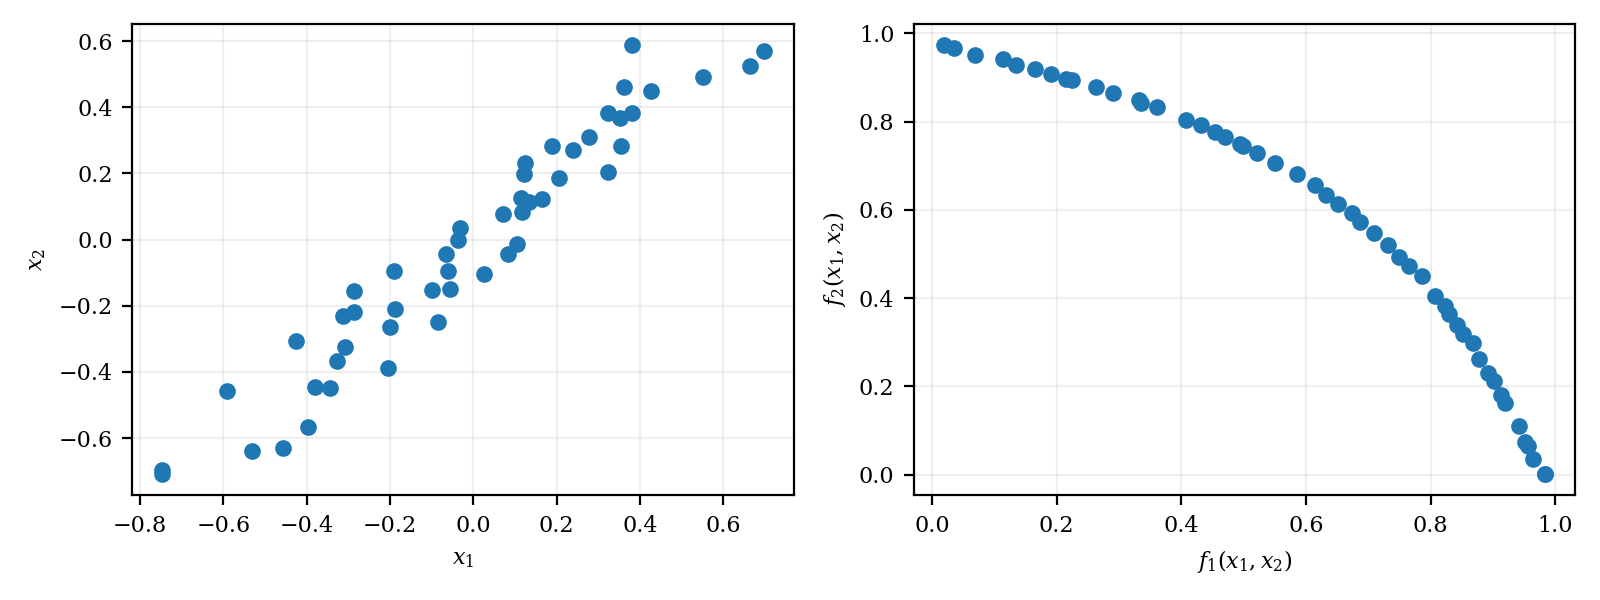

In [14]:
nsga_ii(n_var=2, var_min=-5, var_max=5, max_it=100, n_pop=50, p_crossover=0.5, p_mutation=0.5, mu=0.5, Fobj=MOP1)